# Training and applying a XGBoost model

## Prerequisites:
- you need to have an instance of the geo engine running with active `xgboost` feature
- you need to download an external dataset for this example (see below for more info)
- you need to specify the `admin_session_token` in the `settings-default.toml`
- you need to increase the `tile_limit` in the `settings-default.toml` to a big number (e.g. 10000)
- Set the target directory for the trained xgboost model file
    - this assumes, `geoengine` and `geoengine-python` are located side by side in the filesystem. 
    - change path accordingly if neccessary
    
## NOTE: 
be aware, that this notebook will need some time to run. 

In [1]:
import os

ge_pro_model_path = os.path.join(os.getcwd(), "..", "..", "geoengine/test_data/pro/ml/xgboost/s2_10m_de_marburg")

In [2]:
from datetime import datetime

import geoengine as ge
from geoengine.colorizer import Colorizer
from geoengine import StoredDataset

import numpy as np
import xgboost as xgb
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap



ge.initialize("http://localhost:3030", admin_token="8aca8875-425a-4ef1-8ee6-cdfc62dd7525")
session = ge.get_session()

## Fetch class label data
- Download: [Mundialis Classification Map](https://data.mundialis.de/geodata/lulc-germany/classification_2019/classification_map_germany_2019_v02.tif)
- optional: use the following cell to download the dataset and move it to the correct position in the backend.
- alternatively you'll have to download the dataset manually and put it somewhere under the `test_data` folder of the backend

In [3]:
#file_name = "classification_map_germany_2019_v02.tif"
#URL = "https://data.mundialis.de/geodata/lulc-germany/classification_2019/classification_map_germany_2019_v02.tif"

#outfile = os.path.join(file_name)
#response = requests.get(URL, stream=True)
#with open(outfile,'wb') as output:
#    output.write(response.content)

#os.system(f"mv classification_map_germany_2019_v02.tif {os.path.join(os.getcwd(), '..', '..', 'geoengine/test_data/raster/classification_map_germany_2019_v02.tif')}")

## Define your query parameters here

In [4]:
time = datetime.strptime(
        '2020-06-01T00:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

bbox = [474112, 5612032, 522752, 5646336]
size = [4864, 3431]

resolution = [10, 10]

In [5]:
def workflow_definition(band: str):
    """This method is used to build a sentinel 2 request with the given specification."""
    return {
        'type': 'Raster',
        'operator': {
            'type': 'TemporalRasterAggregation',
            'params': {
                'aggregation': {
                    'type': 'mean',
                    'ignoreNoData': True
                },
                'window': {
                    'granularity': 'days',
                    'step': 10
                }
            },
            'sources': {
                'raster': {
                    'type': 'GdalSource',
                    'params': {
                        'data': {
                            'type': 'external',
                            'providerId': '5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5',
                            'layerId': f'UTM32N:{band}'
                        }
                    }
                },
            }
         }
    }


def query_sentinel_data():
    """This method is used to query the geo engine with the given specs. It returns a dataframe containing the band data."""

    band_ids = ['B02', 'B03', 'B04', 'B08']
    
    

    bands = []

    for b in band_ids:
        workflow = ge.register_workflow(workflow_definition(b))

        task = workflow.save_as_dataset(
            ge.QueryRectangle(
                bbox,
                [time, time],
                resolution=resolution,
                srs = "EPSG:32632"
                ),
            "XGBoost Training Data",
            "A dataset used, to train a xgboost model."
        )
        
        task_status_info = task.wait_for_finish_and_print_status(60)
        
        

        bands.append(StoredDataset.from_response(task_status_info.info))
    
    return bands


In [6]:
stored_ds = query_sentinel_data()
stored_ds

status=running, pct_complete=0.00%, time_estimate=? (± ?), info=None
status=running, pct_complete=0.00%, time_estimate=? (± ?), info=None
status=running, pct_complete=0.00%, time_estimate=? (± ?), info=None
status=running, pct_complete=0.00%, time_estimate=? (± ?), info=None
status=completed, info={'dataset': '54f5753d-ff0f-4681-8893-cda1f985c603', 'upload': '1efcfeaf-3e4e-4ee8-a2f8-588f58c3f8b6'}, time_total=00:03:14
status=running, pct_complete=0.00%, time_estimate=? (± ?), info=None
status=running, pct_complete=0.00%, time_estimate=? (± ?), info=None
status=running, pct_complete=0.00%, time_estimate=? (± ?), info=None
status=running, pct_complete=0.00%, time_estimate=? (± ?), info=None
status=completed, info={'dataset': '459b9ceb-d2f2-4c14-bcc3-937c0fd2fbb9', 'upload': 'f6b0a51a-c0ad-4f70-82ca-476955c2be56'}, time_total=00:03:49
status=running, pct_complete=0.00%, time_estimate=? (± ?), info=None
status=running, pct_complete=0.00%, time_estimate=? (± ?), info=None
status=running, pc

[StoredDataset(dataset_id=54f5753d-ff0f-4681-8893-cda1f985c603, upload_id=1efcfeaf-3e4e-4ee8-a2f8-588f58c3f8b6),
 StoredDataset(dataset_id=459b9ceb-d2f2-4c14-bcc3-937c0fd2fbb9, upload_id=f6b0a51a-c0ad-4f70-82ca-476955c2be56),
 StoredDataset(dataset_id=1805e385-bdd3-4ff8-9c80-b2544cdec5b9, upload_id=25765e89-1955-4fc1-bcc5-8652454fe92d),
 StoredDataset(dataset_id=affbd6e9-af0a-4012-abd8-0a6e5060afa9, upload_id=7bf5d093-49c5-4499-a29a-4dba9c2085ce)]

In [7]:
xrays = []

for ds in stored_ds:
    data = ge.register_workflow({
                "type": "Raster",
                "operator": {
                    "type": "GdalSource",
                    "params": {
                        "data": {
                            "type": "internal",
                            "datasetId": str(ds.dataset_id)
                        }
                    }
                }
            })
    
    xrays.append(data.get_xarray(
    ge.QueryRectangle(
        bbox,
        [time, time],
        resolution=resolution,
        srs = "EPSG:32632"
        )
))
    

In [8]:
df_bands = pd.DataFrame(
        {
            "b2": xrays[0].to_numpy().flatten(),
            "b3": xrays[1].to_numpy().flatten(),
            "b4": xrays[2].to_numpy().flatten(),
            "b8": xrays[3].to_numpy().flatten()
        }
    )

df_bands

,b2,b3,b4,b8
0,4059,3859,3449,5483
1,4043,3819,3512,5296
2,3981,3770,3518,5081
3,3937,3721,3481,5089
4,3900,3725,3455,5141
...,...,...,...,...
16688379,3630,3697,3671,6036
16688380,3508,3598,3465,6171
16688381,3425,3496,3378,6320
16688382,3290,3387,3323,6215


## Get the class labels
- The classification dataset is not part of the geo engine. Therefore we need to specify the details and add the dataset manually.

In [9]:
file_path = "raster/classification_map_germany_2019_v02.tif" # specify file path relative to volume path

rasterband_channel = 1

geo_transform = ge.GdalDatasetGeoTransform({
  "originCoordinate": [279370.0, 6102450.0], 
  "xPixelSize": 10.0, 
  "yPixelSize": -10.0
})

width = 64293
height = 86760

file_not_found_handling = ge.FileNotFoundHandling.NODATA

gdal_params = ge.GdalDatasetParameters({
  "filePath": file_path, 
  "rasterbandChannel": rasterband_channel, 
  "geoTransform": geo_transform,
  "width": width, 
  "height": height , 
  "fileNotFoundHandling": file_not_found_handling, 
  "noDataValue": None, 
  "propertiesMapping": None, 
  "gdalOpenOptions": None, 
  "gdalConfigOptions": None, 
  "allowAlphabandAsMask": True
})

result_descriptor_dict = {
      "dataType": "I16",
      "spatialReference": "EPSG:32632",
      "measurement": {
        "type": "classification",
        "measurement": "Landnutzung",
        "classes": {
            "0": "Wald",
            "1": "niedrige Vegetation",
            "2": "Wasser",
            "3": "Bebauung",
            "4": "offener Boden",
            "5": "Landwirtschaft"
        }
      },
      "noDataValue": -1000.0,
      "time": {
          "start": "2020-01-01T00:00:00.000Z",
          "end": "2020-12-01T00:00:00.000Z"
      },
      "bbox": {
        "upperLeftCoordinate": [279370.0, 6102450.0],
        "lowerRightCoordinate": [922300.0, 5234850.0]
      },
      "resolution": {
        "x": 10.0,
        "y": -10.0
      }
    }

result_descriptor = ge.RasterResultDescriptor(result_descriptor_dict)

meta_data = ge.GdalMetaDataStatic({
  "type": "GdalStatic",
  "time": None, 
  "params": gdal_params, 
  "resultDescriptor": result_descriptor
})

meta_data

{'type': 'GdalStatic',
 'time': None,
 'params': {'filePath': 'raster/classification_map_germany_2019_v02.tif',
  'rasterbandChannel': 1,
  'geoTransform': {'originCoordinate': [279370.0, 6102450.0],
   'xPixelSize': 10.0,
   'yPixelSize': -10.0},
  'width': 64293,
  'height': 86760,
  'fileNotFoundHandling': <FileNotFoundHandling.NODATA: 'NoData'>,
  'noDataValue': None,
  'propertiesMapping': None,
  'gdalOpenOptions': None,
  'gdalConfigOptions': None,
  'allowAlphabandAsMask': True},
 'resultDescriptor': Data type:         I16
 Spatial Reference: EPSG:32632
 Measurement:       Landnutzung (0: Wald, 1: niedrige Vegetation, 2: Wasser, 3: Bebauung, 4: offener Boden, 5: Landwirtschaft)}

### now we can add the dataset, making it available for further usage within the geo engine

In [10]:
volumes = ge.volumes()
dataset_id = ge.add_public_raster_dataset(volumes[0].name, "classification_map_germany_2019_v02", meta_data)

[{'name': 'test_data', 'path': 'test_data/'}]
alksdfjlkasj


In [11]:
workflow = ge.register_workflow({
    "type": "Raster",
    "operator": {
        "type": "GdalSource",
        "params": {
            "data": {
                "type": "internal",
                "datasetId": str(dataset_id)
            },
        }
    }
})

workflow.get_result_descriptor()

Data type:         I16
Spatial Reference: EPSG:32632
Measurement:       Landnutzung (0: Wald, 1: niedrige Vegetation, 2: Wasser, 3: Bebauung, 4: offener Boden, 5: Landwirtschaft)

## Use the geo engine to provide the class labels for the query rectangle.

<AxesSubplot: ylabel='Frequency'>

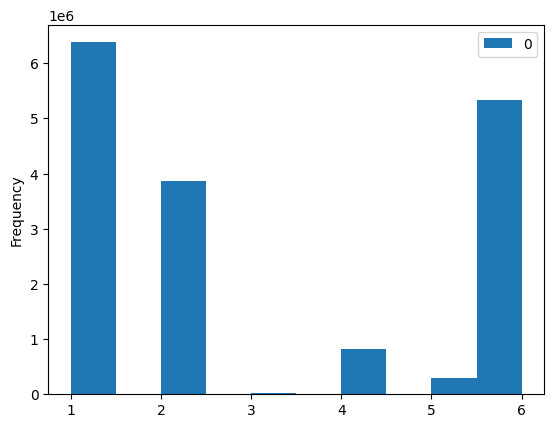

In [12]:
time = datetime.strptime(
    '2020-01-01T00:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

data = workflow.get_xarray(
    ge.QueryRectangle(
        bbox,
        [time, time],
        resolution=resolution,
        srs = "EPSG:32632"
        )
)

label = pd.DataFrame(data.squeeze().to_numpy().flatten())

# XGBoost wants the labels to be integers starting from zero
label[0] = label[0].map({
    0: 0,
    10: 1,
    20: 2,
    30: 3,
    40: 4,
    50: 5,
    60: 6,
})


label.plot.hist()

# XGBoost

## Set parameters and train a model

In [13]:
dtrain = xgb.DMatrix(df_bands, label=label)
param = {'max_depth': 6, 'eta': 0.5, 'objective': 'multi:softmax', 'num_class': 7, 'validate_parameters': 1, 'tree_method': 'hist'}
evallist = [(dtrain, 'train')]
num_round = 2
bst = xgb.train(param, dtrain, num_round, evals=evallist)

[0]	train-mlogloss:1.39885
[1]	train-mlogloss:1.20979


## Store the xgboost model file

In [14]:
bst.save_model(os.path.join(ge_pro_model_path, 'mod.json'))

## Define workflow for XGBoost predictions
- set the operator
- set the source bands used to predict from
- define the query parameters

In [15]:
workflow = ge.register_workflow({
                "type": "Raster",
                "operator": {
                    "type": "XgboostOperator",
                    "params": {
                        "modelSubPath": "xgboost/s2_10m_de_marburg/mod.json",
                        "noDataValue": -1000.0,
                    },
                    "sources": {
                        "rasters": [
                            {
                    "type": "GdalSource",
                    "params": {
                        "data": {
                            "type": "internal",
                            "datasetId": str(stored_ds[0].dataset_id)
                        }
                    
                }
            },
                            {
               
                    "type": "GdalSource",
                    "params": {
                        "data": {
                            "type": "internal",
                            "datasetId": str(stored_ds[1].dataset_id)
                        }
                   
                }
            },
                            {
               
                    "type": "GdalSource",
                    "params": {
                        "data": {
                            "type": "internal",
                            "datasetId": str(stored_ds[2].dataset_id)
                        }
                    
                }
            },
                            {
               
                    "type": "GdalSource",
                    "params": {
                        "data": {
                            "type": "internal",
                            "datasetId": str(stored_ds[3].dataset_id)
                        }
                    }
                }
            
                        ] 
                    }
                }
            })



time = datetime.strptime(
    '2020-06-01T00:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

## Execute the query
- this will trigger the xgboost prediction operator and fetch the newly created tiles

In [16]:
predictions = workflow.get_xarray(
ge.QueryRectangle(
        bbox,
        [time, time],
        resolution=resolution,
        srs = "EPSG:32632"
        ),
)

predictions

<xarray.DataArray (band: 1, y: 3431, x: 4864)>
array([[[1., 1., 1., ..., 6., 6., 6.],
        [1., 1., 1., ..., 6., 6., 6.],
        [1., 1., 1., ..., 6., 6., 6.],
        ...,
        [1., 1., 2., ..., 6., 6., 6.],
        [1., 1., 1., ..., 6., 6., 6.],
        [1., 1., 1., ..., 6., 6., 6.]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.741e+05 4.741e+05 ... 5.227e+05 5.227e+05
  * y            (y) float64 5.646e+06 5.646e+06 ... 5.612e+06 5.612e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    crs:           EPSG:32632
    res:           (10.0, -10.0)
    transform:     | 10.00, 0.00, 474112.00|\n| 0.00,-10.00, 5646336.00|\n| 0...

## Show distribution of predicted values

(array([6907873.,       0., 2150120.,       0.,   12040.,       0.,
         632892.,       0.,       0., 6985459.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

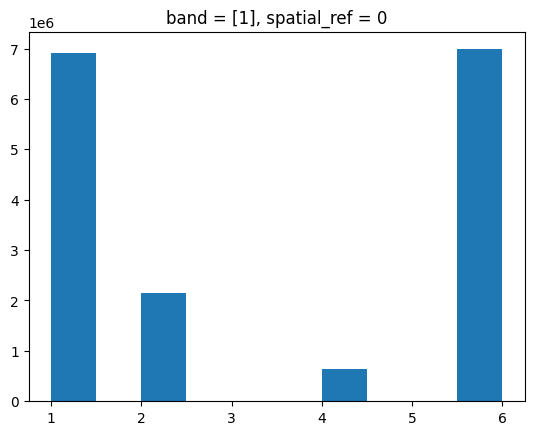

In [17]:
predictions.plot.hist()

## Plot the data

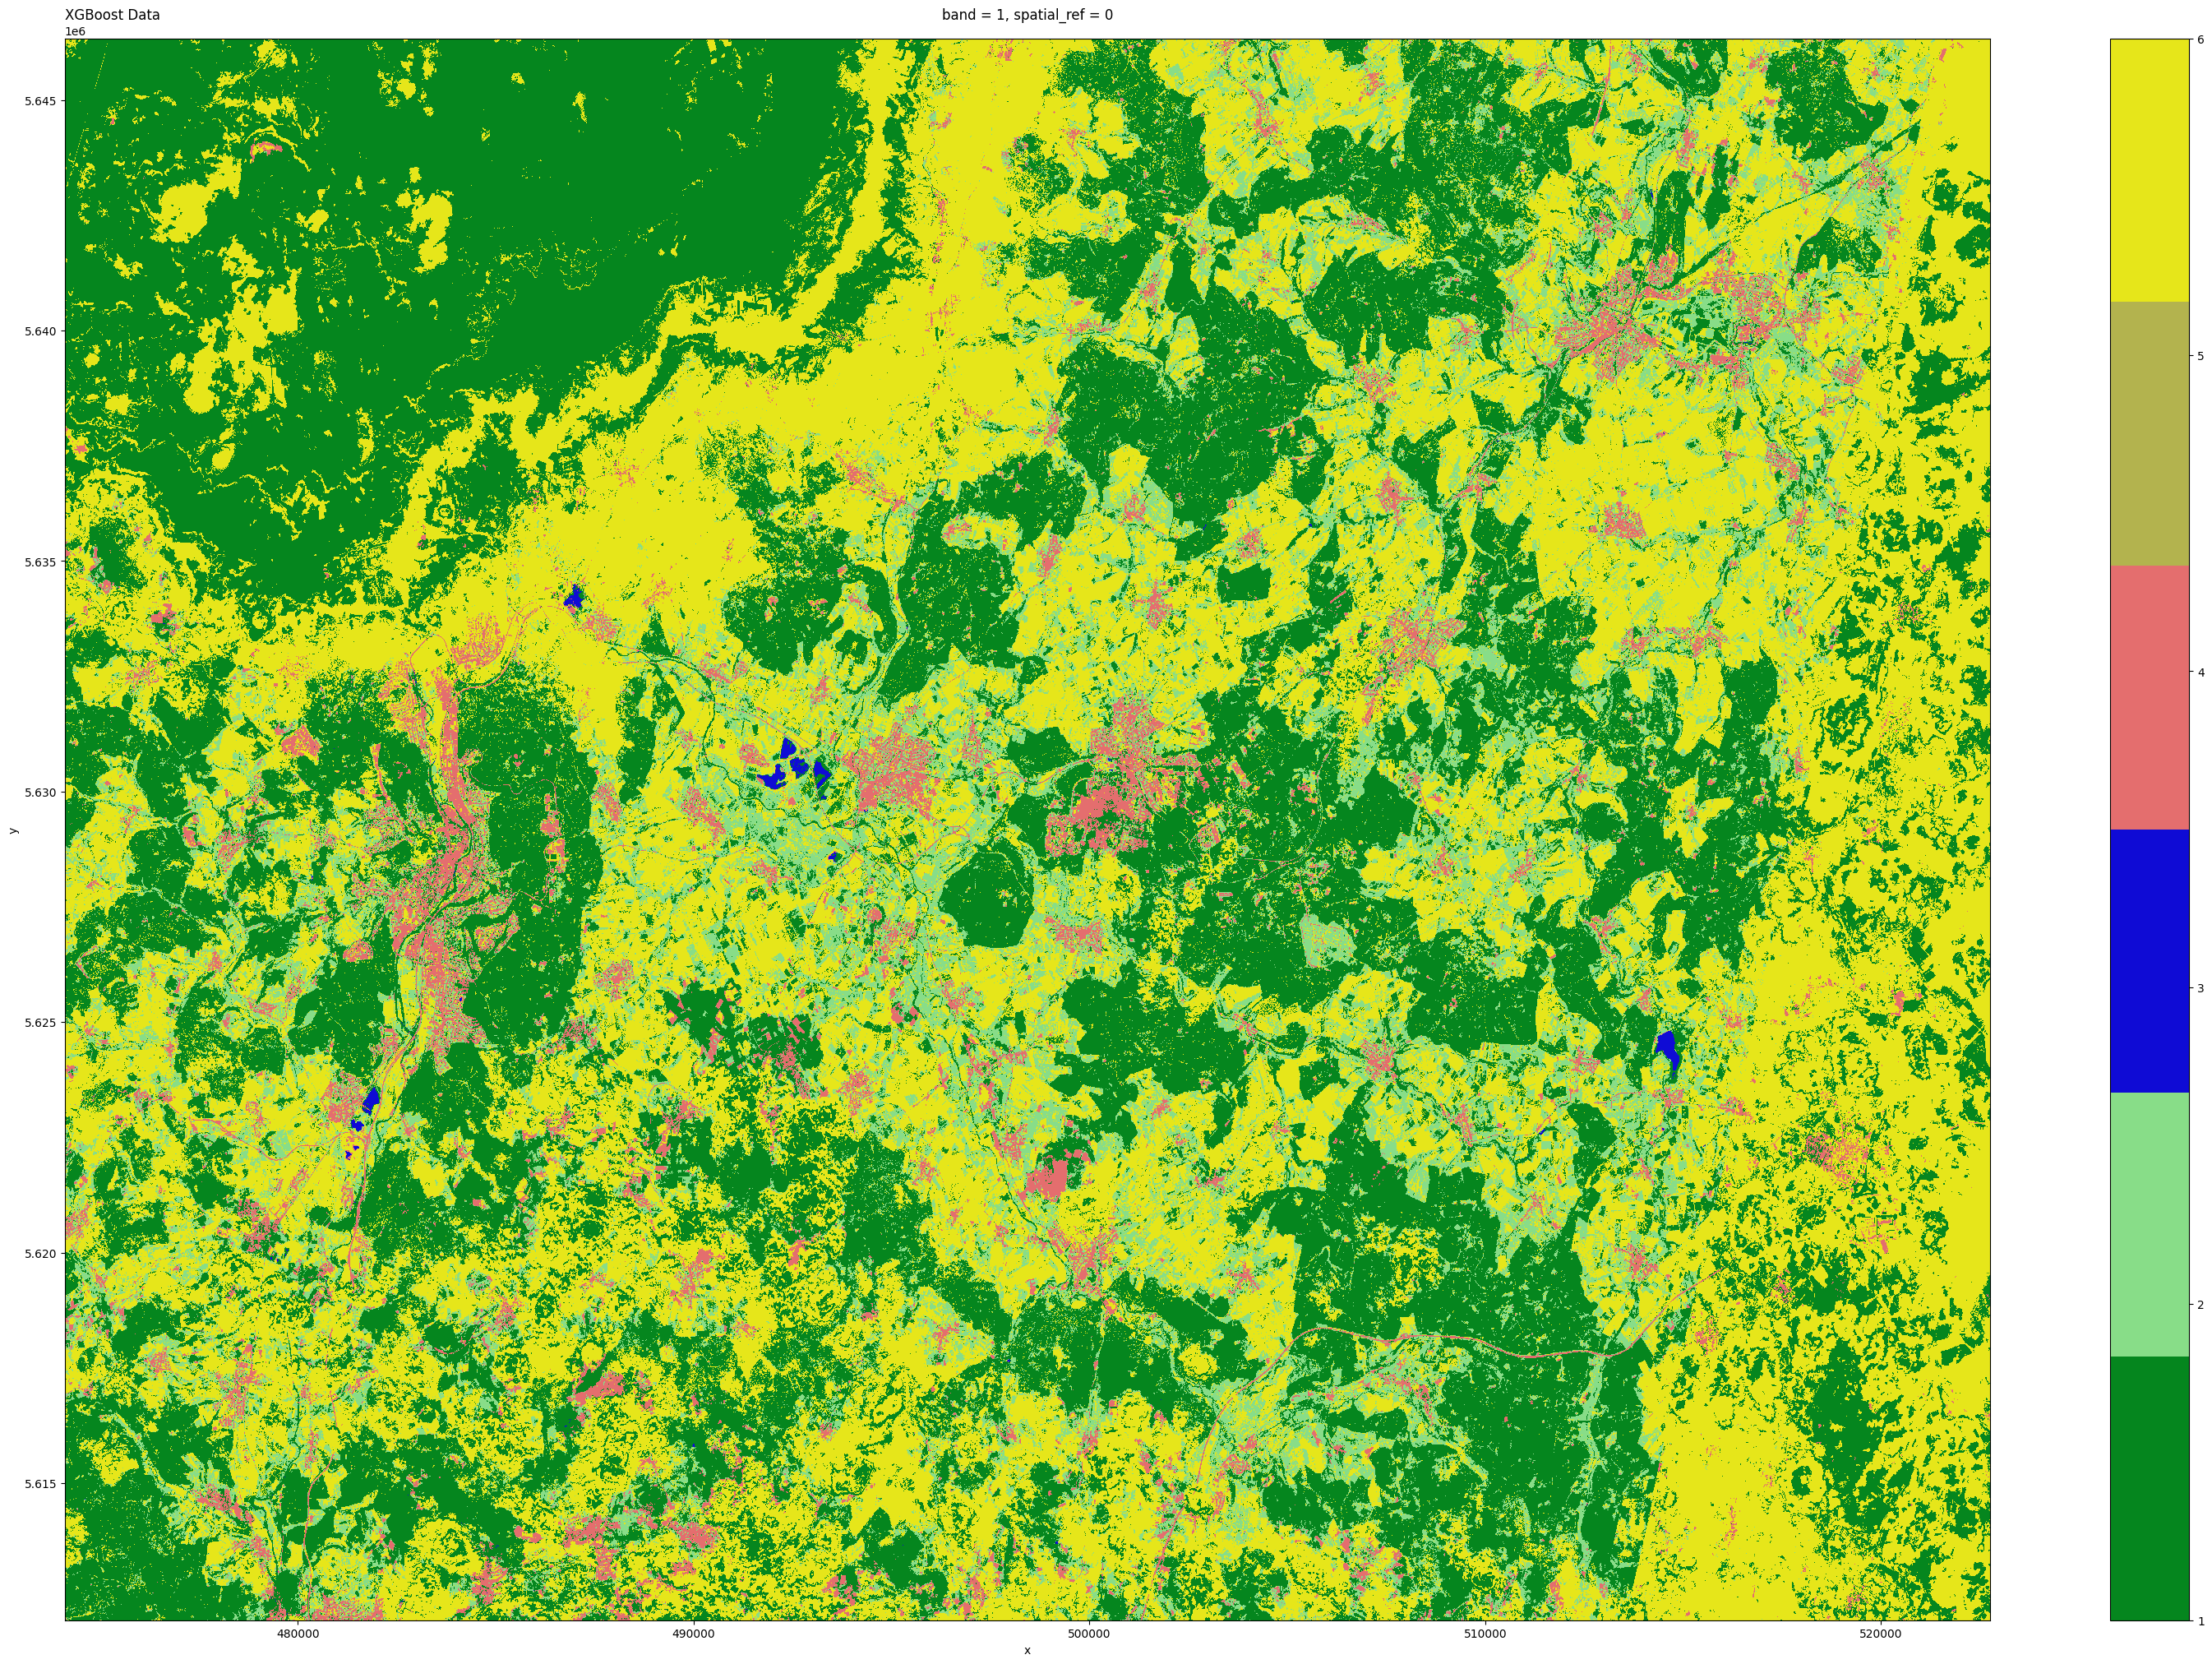

In [18]:
figure, axis = plt.subplots(nrows=1, figsize=(30,20))
axis.set_title('XGBoost Data', loc='left')

plt.tight_layout()

# we need to remove the colors, that haven't been predicted
cmap = ListedColormap([
    (4/256, 135/256, 29/256, 255/256), # green
    (137/256, 222/256, 137/256, 255/256), # lime
    (14/256, 10/256, 214/256, 255/256), # blue
    (229/256, 109/256, 109/256, 255/256), # pastel red
    (180/256, 180/256, 77/256, 255/256), # dark yellow/greenish
    (231/256, 231/256, 25/256, 255/256), # yellow
    #(0/256, 0/256, 0/256, 0/256), # no data color
])


predictions.plot(ax=axis, cmap=cmap)